<a href="https://colab.research.google.com/github/nunezal/berryBot/blob/main/copy_of_berrybot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and requirements

In [28]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!pip install playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

# Set up GPU rendering (your existing code - keep this)
import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )
print('Installation successful.')

# Imports from Playground example
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from datetime import datetime
import functools
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import manipulation_params

import os
import shutil  # Import the shutil module
import mediapy as media

# List available environments
all_envs = registry.manipulation.ALL
print(all_envs)

env_name = 'PandaPickCubeOrientation' # Starting with this base environment
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
print(env_cfg)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.
['AlohaSinglePegInsertion', 'PandaPickCube', 'PandaPickCubeOrientation', 'PandaPickCubeCartesian', 'PandaOpenCabinet', 'PandaRobotiqPushCube', 'LeapCubeReorient', 'LeapCubeRotateZAxis']
action_repeat: 1
action_scale: 0.04
ctrl_dt: 0.02
episode_length: 150
reward_config:
  scales:
    box_target: 8.0
    gripper_box: 4.0
    no_floor_collision: 0.25
    robot_target_qpos: 0.3
sim_dt: 0.005



## Training Env

Meshes copied to package mesh directory: /usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda


""

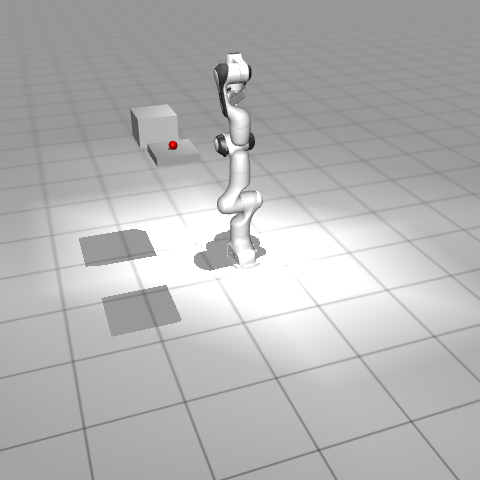

In [30]:
# --- Define target package mesh directory from the error message ---
target_package_mesh_dir = "/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda"

# --- Source mesh directory (where you have meshes in Google Drive) ---
source_mesh_dir = "/content/drive/MyDrive/robo/arm_mesh"

# --- Copy Meshes to Package Directory ---
os.makedirs(target_package_mesh_dir, exist_ok=True)  # Create target directory if it doesn't exist

for filename in os.listdir(source_mesh_dir):
    if filename.endswith((".stl", ".obj", ".msh")):  # Check for common mesh file extensions
        source_path = os.path.join(source_mesh_dir, filename)
        target_path = os.path.join(target_package_mesh_dir, filename)
        # Handle existing files (overwrite, skip, or prompt)
        if os.path.exists(target_path):
            continue  # Skip existing files
            # Or: raise FileExistsError(f"File {filename} already exists")
        shutil.copy2(source_path, target_path)  # Copy while preserving metadata
print(f"Meshes copied to package mesh directory: {target_package_mesh_dir}")

# --- Find mjx_panda.xml Path (still needed for include) ---
def find_mjx_panda_xml_path():
    """Finds the absolute path to mjx_panda.xml."""
    import mujoco_playground
    playground_path = os.path.dirname(mujoco_playground.__file__)

    mjx_panda_path = None
    possible_paths_panda = [
        "/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml",
        os.path.join(playground_path, '_src', 'manipulation', 'franka_emika_panda', 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'manipulation', 'franka_emika_panda', 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'franka_emika_panda', 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'xmls', 'mjx_panda.xml'),
        os.path.join(playground_path, 'mjx_panda.xml')
    ]

    for path in possible_paths_panda:
        if os.path.exists(path):
            mjx_panda_path = path
            break
    return mjx_panda_path

mjx_panda_path = find_mjx_panda_xml_path()
if not mjx_panda_path:
    raise FileNotFoundError("Could not find mjx_panda.xml")


mjx_panda_path = '/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml'

modified_xml_string = f"""
<mujoco model="berry_picking_playground_scratch">
    <!-- Include panda robot from mjx_panda.xml using absolute path -->
    <include file="{mjx_panda_path}"/>

    <option timestep="0.002" iterations="100" solver="Newton" gravity="0 0 -9.81"/>



    <visual>
      <headlight diffuse=".8 .8 .8" ambient=".2 .2 .2" specular="1 1 1"/>
      <global azimuth="-20" elevation="-30"/>
      <rgba force="1 0 0 1"/>
      <map force="0.01"/>
      <quality shadowsize="8192"/>
      <scale contactwidth="0.075" contactheight="0.025" forcewidth="0.05" com="0.05" framewidth="0.01" framelength="0.2"/>
    </visual>

    <size nstack="3000"/>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
        <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 .2 .3" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>
        <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="1 1" texuniform="true"/>
        <material name="berry" rgba="0.8 0 0 1"/>
        <material name="plate" rgba="0.7 0.7 0.7 1"/>
        <material name="bowl" rgba="0.8 0.8 0.8 1"/>

        <!-- Materials -->
        <material name="white2" rgba="1 1 1 1"/>
        <material name="off_white2" rgba="0.901961 0.921569 0.929412 1"/>
        <material name="black2" rgba="0.25 0.25 0.25 1"/>
        <material name="green2" rgba="0 1 0 1"/>
        <material name="light_blue2" rgba="0.039216 0.541176 0.780392 1"/>

        <!-- Ground plane texture/material -->
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0"/>
    </asset>

    <worldbody>
        <!-- Add Camera here inside worldbody -->
        <camera name="closeup_berry" pos="0 0 2" quat="0.707 0.707 0 0" mode="targetbodycom" target="berry"/>

        <!-- Ground plane -->
        <geom name="floor" size="0 0 0.05" type="plane" material="groundplane" contype="1"/>

        <!-- Plate -->
        <body name="plate" pos="-0.2 0.4 0.75">
            <geom name="plate_geom" type="box" size="0.1 0.1 0.02" material="plate"/>
        </body>

        <!-- Bowl -->
        <body name="bowl" pos="0.2 0.4 0.75">
            <geom name="bowl_geom" type="box" size="0.1 0.1 0.075" material="bowl"/>
        </body>

        <!-- Berry -->
        <body name="berry" pos="-0.2 0.4 0.785">
            <joint name="berry_joint" type="free" damping="0.1"/>
            <geom name="berry_geom" type="capsule" size="0.02 0.0001" fromto="0 0 -0.0001 0 0 0.0001" material="berry"/>
        </body>

         <!-- Panda Robot (included from mjx_panda.xml) -->
    </worldbody>
</mujoco>
        """

if modified_xml_string:
    # Render the scene
    model = mujoco.MjModel.from_xml_string(modified_xml_string)
    data = mujoco.MjData(model)
    with mujoco.Renderer(model, width=480, height=480) as renderer:
        mujoco.mj_forward(model, data)
        renderer.update_scene(data)
        image = renderer.render()
        media.show_image(image)

In [31]:
from mujoco_playground._src import mjx_env
from ml_collections import config_dict
import os
import jax
import jax.numpy as jp
import mediapy as media
import numpy as np
import mujoco
from mujoco.mjx._src import math
from typing import Dict
from mujoco_playground._src.manipulation.franka_emika_panda import pick

self.config inside _debug_config: True


/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/xla.py:155: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Step Reward: 0.353723406791687, Metrics: {'berry_bowl_move': Array(0., dtype=float32), 'berry_in_bowl_bonus': Array(0., dtype=float32, weak_type=True), 'gripper_berry_contact': 0.0, 'gripper_berry_grasp': Array(0., dtype=float32, weak_type=True), 'gripper_berry_lift': 0.0, 'gripper_berry_reach': Array(0.055, dtype=float32), 'robot_target_qpos': Array(0.299, dtype=float32), 'berry_in_bowl': Array(0., dtype=float32)}, Done: 0.0


100%|██████████| 1/1 [00:00<00:00, 69.57it/s]


""

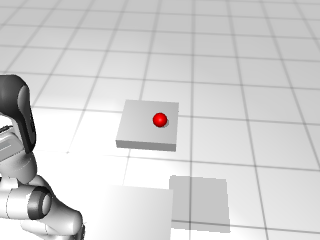

Rendered frame from CustomBerryPickingEnv using camera_id=1 (index)


In [37]:

def default_config() -> config_dict.ConfigDict:
    """Returns the default config for berry picking task."""
    config = config_dict.create(
        ctrl_dt=0.02,
        sim_dt=0.005, # Experiment with 0.005 if needed
        episode_length=1000, # Increased episode length
        action_repeat=1,
        action_scale=0.02, # Action scale
        reward_config=config_dict.create(
            scales=config_dict.create(
                gripper_berry_reach=5.0,    # Increased reach reward
                gripper_berry_contact=3.0,  # New reward for contact
                gripper_berry_lift=8.0,     # New reward for lifting
                gripper_berry_grasp=4.0,    # Maintained grasp reward
                berry_bowl_move=5.0,        # Move to bowl reward
                berry_in_bowl_bonus=10.0,   # Bowl placement bonus
                robot_target_qpos=0.3,      # New reward for robot target qpos
            )
        ),
    )
    return config


class CustomBerryPickingEnv(pick.PandaPickCube):
    def __init__(self, config: config_dict.ConfigDict = default_config()): # Take config as input
        self.config = config # Assign config to self
        # --- XML Path Setup ---
        mjx_panda_path = '/usr/local/lib/python3.11/dist-packages/mujoco_playground/external_deps/mujoco_menagerie/franka_emika_panda/mjx_panda.xml'
        modified_xml_string = f"""
<mujoco model="berry_picking_playground_scratch">
    <!-- Include panda robot from mjx_panda.xml using absolute path -->
    <include file="{mjx_panda_path}"/>

    <option timestep="{config.sim_dt}" iterations="100" solver="Newton" gravity="0 0 -9.81"/>

    <!-- Increased friction parameters -->
    <default>
        <geom friction="1.0 0.005 0.0001"/>
    </default>

    <visual>
      <headlight diffuse=".8 .8 .8" ambient=".2 .2 .2" specular="1 1 1"/>
      <global azimuth="-20" elevation="-30"/>
      <rgba force="1 0 0 1"/>
      <map force="0.01"/>
      <quality shadowsize="8192"/>
      <scale contactwidth="0.075" contactheight="0.025" forcewidth="0.05" com="0.05" framewidth="0.01" framelength="0.2"/>
    </visual>

    <size nstack="3000"/>

    <asset>
        <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
        <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 .2 .3" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>
        <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="1 1" texuniform="true"/>
        <material name="berry" rgba="0.8 0 0 1"/>
        <material name="plate" rgba="0.7 0.7 0.7 1"/>
        <material name="bowl" rgba="0.8 0.8 0.8 1"/>

        <!-- Materials -->
        <material name="white2" rgba="1 1 1 1"/>
        <material name="off_white2" rgba="0.901961 0.921569 0.929412 1"/>
        <material name="black2" rgba="0.25 0.25 0.25 1"/>
        <material name="green2" rgba="0 1 0 1"/>
        <material name="light_blue2" rgba="0.039216 0.541176 0.780392 1"/>

        <!-- Ground plane texture/material -->
        <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
        <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0"/>
    </asset>

    <worldbody>
        <!-- Add Camera here inside worldbody -->
        <camera name="closeup_berry" pos="0.5 0.5 1.5"  mode="targetbodycom" target="berry"/>

        <!-- Ground plane -->
        <geom name="floor" size="0 0 0.05" type="plane" material="groundplane" contype="1"/>

        <!-- Plate -->
        <body name="plate" pos="-0.2 0.4 0.75">
            <geom name="plate_geom" type="box" size="0.1 0.1 0.02" material="plate"/>
        </body>

        <!-- Bowl -->
        <body name="bowl" pos="0.2 0.4 0.75">
            <geom name="bowl_geom" type="box" size="0.1 0.1 0.075" material="bowl"/>
        </body>

        <!-- Berry -->
        <!-- Modified berry with increased size and better graspable shape -->
        <body name="berry" pos="-0.2 0.4 0.785">
            <joint name="berry_joint" type="free" damping="0.1"/>
            <!-- Changed to sphere with larger size and added contact sensors -->
            <geom name="berry_geom" type="sphere" size="0.025" material="berry" mass="0.05"/>
            <site name="berry_top" pos="0 0 0.025" size="0.001"/>
            <site name="berry_bottom" pos="0 0 -0.025" size="0.001"/>
        </body>

         <!-- Panda Robot (included from mjx_panda.xml) -->
    </worldbody>
</mujoco>
        """
        xml_path_custom = "custom_panda_berry.xml"
        with open(xml_path_custom, "w") as f:
            f.write(modified_xml_string)
        xml_path = os.path.abspath(xml_path_custom)
        self._xml_path = xml_path  # Set self._xml_path




        super().__init__(config) # Now call super() with the config


        self._debug_config() # Call the debug method immediately after super().__init__


        # --- Load mj_model and mjx_model AFTER super().__init__ ---
        self._mj_model = mujoco.MjModel.from_xml_path(xml_path)
        self._mjx_model = mjx.put_model(self.mj_model)

        self._robot_arm_qposadr = self.mj_model.joint("joint1").qposadr[0] # Assuming panda_joint1 is the start of arm joints, adjust if needed. Panda arm has 7 joints.
        self._robot_arm_qpos_num = 7 # Number of joints in Panda arm

        # --- Store initial qpos and qvel ---
        self._init_qpos = jp.array(self.mj_model.qpos0)
        self._init_qvel = jp.zeros(self.mj_model.nv)  # Create qvel as zeros

        # --- Get body and geom IDs ---
        self.berry_body_id = self.mj_model.body("berry").id
        self.bowl_body_id = self.mj_model.body("bowl").id
        self.gripper_site_id = self.mj_model.site("gripper").id
        self.berry_geom_id = self.mj_model.geom("berry_geom").id
        self.bowl_geom_id = self.mj_model.geom("bowl_geom").id

        # --- Store initial berry position ---
        self._init_berry_pos = self._init_qpos[self.mj_model.joint("berry_joint").qposadr[0]:self.mj_model.joint("berry_joint").qposadr[0]+3]

    def _debug_config(self):
        print("self.config inside _debug_config:", hasattr(self, 'config')) # Check if self.config exists

    # --- Implement abstract methods as properties (NO lazy loading) ---
    @property
    def action_size(self):
        return 8

    @property
    def mj_model(self):
        return self._mj_model  # Return directly, no lazy loading

    @property
    def mjx_model(self):
        return self._mjx_model  # Return directly, no lazy loading

    @property
    def xml_path(self):
        return self._xml_path

    # --- reset method ---
    def reset(self, rng: jax.Array) -> mjx_env.State:
        rng, next_rng = jax.random.split(rng)

        # Find the joint address for the 'berry' body's free joint
        berry_joint_id = self.mj_model.joint("berry_joint").id
        berry_qpos_adr = self.mj_model.jnt_qposadr[berry_joint_id]

        # Initialize berry position (example: random position around starting point)
        berry_pos = jax.random.uniform(
            rng,
            (3,),
            minval=jp.array([-0.1, -0.1, 0.0]),  # Small random offset
            maxval=jp.array([0.1, 0.1, 0.0]),
        ) + self._init_berry_pos  # Add the initial position


        # Create a copy of the initial qpos and modify the berry's position
        init_qpos = self._init_qpos.at[berry_qpos_adr:berry_qpos_adr + 3].set(berry_pos)


        data = mjx_env.init(self.mjx_model, init_qpos, self._init_qvel)
        obs = self._get_obs(data)
        reward = 0.0
        done = 0.0
        metrics = {k: 0.0 for k in self.config.reward_config.scales.keys()} # Initialize metrics
        metrics["berry_in_bowl"] = 0.0  # Custom metric
        info = {}
        return mjx_env.State(data, obs, reward, done, metrics, info)


    def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
        # Apply actions with scaling
        delta = action * self.config.action_scale
        ctrl = state.data.ctrl + delta
        # Assuming your Panda robot has joint limits, you might want to clip actions or ctrl here
        # ctrl = jp.clip(ctrl, self._lowers, self._uppers) # Example if you have _lowers and _uppers defined

        data = mjx_env.step(self.mjx_model, state.data, ctrl)

        # Get observation
        obs = self._get_obs(data)

        # Calculate rewards
        rewards = self._get_reward(data, state.info)
        scaled_rewards = {
            k: v * self.config.reward_config.scales[k]
            for k, v in rewards.items()
        }
        reward = sum(scaled_rewards.values())

        # Check termination conditions
        berry_in_bowl = self.check_berry_in_bowl(data)
        done = (
            berry_in_bowl
            | jp.isnan(data.qpos).any()
            | jp.isnan(data.qvel).any()
        )
        done = done.astype(jp.float32)

        # Update metrics
        # Create a new metrics dictionary to avoid modifying the original
        metrics = state.metrics.copy()
        metrics.update(scaled_rewards)
        metrics["berry_in_bowl"] = berry_in_bowl.astype(float)

        # Create a new info dictionary, preserving existing keys and adding new ones
        info = state.info.copy()  # Preserve the original info structure

        # Return a new State object with updated data
        return mjx_env.State(data, obs, reward, done, metrics, info)

    def _get_obs(self, data):
        gripper_pos = data.site_xpos[self.gripper_site_id]
        gripper_mat = data.site_xmat[self.gripper_site_id].ravel() # Or use quat if you prefer
        berry_pos = data.xpos[self.berry_body_id]
        bowl_pos = data.xpos[self.bowl_body_id]

        obs = jp.concatenate([
            data.qpos,
            data.qvel,
            gripper_pos,
            gripper_mat[3:], # Or gripper_mat.ravel()
            berry_pos, # Or berry_mat.ravel() if you have orientation
            berry_pos - gripper_pos, # Relative position gripper to berry
            bowl_pos - berry_pos, # Relative position berry to bowl
            data.ctrl, # Include control signal
        ])
        return obs

    def _get_reward(self, data: mjx.Data, info: dict) -> dict:
        """Calculates the reward based on the current state."""

        gripper_pos = data.site_xpos[self.gripper_site_id]
        berry_pos = data.xpos[self.berry_body_id]
        bowl_pos = data.xpos[self.bowl_body_id]

        # --- Staged Rewards ---

        # 1. Gripper Reach Berry Reward
        dist_gripper_berry = jp.linalg.norm(gripper_pos - berry_pos)
        gripper_berry_reach_reward = 1 - jp.tanh(5 * dist_gripper_berry)

        # 2. Gripper Grasp Berry Reward (maintain proximity)
        gripper_berry_grasp_reward = jp.where(
            dist_gripper_berry < 0.03, # Threshold for "grasp"
            1.0, # Constant reward while "grasping"
            0.0
        )

        # 3. Berry Move to Bowl Reward (only when "grasped")
        berry_bowl_move_reward = jp.where(
            dist_gripper_berry < 0.03,  # Condition: "grasped"
            1 - jp.tanh(3 * jp.linalg.norm(berry_pos - bowl_pos)),
            0.0
        )

        # 4. Berry in Bowl Bonus
        berry_in_bowl_bonus = jp.where(self.check_berry_in_bowl(data), 1.0, 0.0)

        # 5. Robot Target QPOS Reward
        robot_target_qpos_reward = 1 - jp.tanh(
            jp.linalg.norm(
                data.qpos[self._robot_arm_qposadr:self._robot_arm_qposadr + self._robot_arm_qpos_num]
                - self._init_qpos[self._robot_arm_qposadr:self._robot_arm_qposadr + self._robot_arm_qpos_num]
            )
        )


        rewards = {
            "gripper_berry_reach": gripper_berry_reach_reward,
            "gripper_berry_grasp": gripper_berry_grasp_reward,
            "berry_bowl_move": berry_bowl_move_reward,
            "berry_in_bowl_bonus": berry_in_bowl_bonus,
            "robot_target_qpos": robot_target_qpos_reward,
        }

        return rewards

    def check_berry_in_bowl(self, data):
        """Check for the berry inside the bowl using a simple box check"""
        berry_pos = data.geom_xpos[self.berry_geom_id]
        bowl_pos = data.geom_xpos[self.bowl_geom_id]
        bowl_size = self.mj_model.geom_size[self.bowl_geom_id]

        # Simple AABB check (Axis-Aligned Bounding Box)
        within_x = (berry_pos[0] >= bowl_pos[0] - bowl_size[0]) & (berry_pos[0] <= bowl_pos[0] + bowl_size[0])
        within_y = (berry_pos[1] >= bowl_pos[1] - bowl_size[1]) & (berry_pos[1] <= bowl_pos[1] + bowl_size[1])
        within_z = (berry_pos[2] >= bowl_pos[2]) & (berry_pos[2] <= bowl_pos[2] + 0.4)
        in_bowl = within_x & within_y & within_z
        return in_bowl

# 3. Instantiate and Test
env = CustomBerryPickingEnv()
reset_state = env.reset(jax.random.PRNGKey(0))


# Take a few steps and check rewards
for _ in range(1):
    action = jp.zeros(env.action_size)  # Zero action for now
    state = env.step(reset_state, action)
    print(f"Step Reward: {state.reward}, Metrics: {state.metrics}, Done: {state.done}")
    reset_state = state # Update state

# Render and display (after some steps)
# Render and display (after some steps)
frame = env.render([state], camera="closeup_berry")[0] # Try camera_id=1 (index)
media.show_image(frame)
print("Rendered frame from CustomBerryPickingEnv using camera_id=1 (index)")


## Training

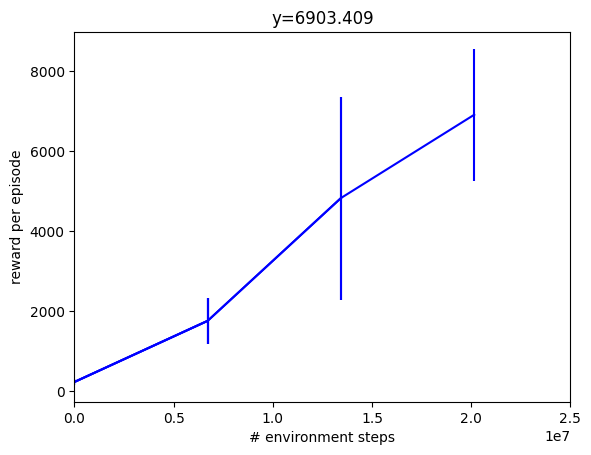

time to jit: 0:01:45.349553
time to train: 0:22:50.793065


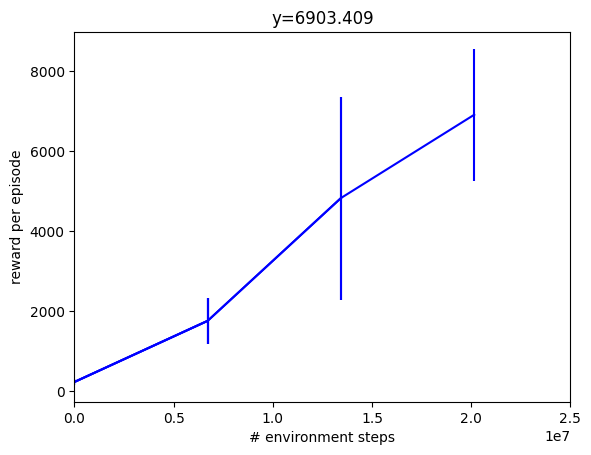

In [38]:
ppo_params = {
    'action_repeat': 1,
    'batch_size': 512,
    'discounting': 0.97,
    'entropy_cost': 0.02,
    'episode_length': 1000,
    'learning_rate': 0.002,
    'network_factory': {
        'policy_hidden_layer_sizes': (32, 32, 32, 32),
        'policy_obs_key': 'state',
        'value_hidden_layer_sizes': (256, 256, 256, 256, 256),
        'value_obs_key': 'state'
    },
    'normalize_observations': True,
    'num_envs': 2048,
    'num_evals': 4,
    'num_minibatches': 32,
    'num_timesteps': 20000000,
    'num_updates_per_batch': 8,
    'reward_scaling': 1.0,
    'unroll_length': 10
}


x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_training_params:

  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_training_params["network_factory"]
  )

  del ppo_training_params["network_factory"]

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    seed=1
)


make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [39]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1
episode_length = 1000

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)